## Part II: Neural Networks
Among all the built ML models Logistic Regression showed the best results. It had an F1 score of 57%. F-measure was chosen due to the dataset imbalance and the importance of both false negatives and false positives. The result of the F score was not ideal. It indicated that the model's performance was a little better than average, and neural networks were tried out to improve the accuracy of the predictions.

Neural networks have been used extensively in natural language processing and they provide powerful new tools for modeling language. They are applied to many language problems: unsupervised learning of word representations, supervised text classification, language modeling, etc. They are well suited for learning the complex underlying structure of a sentence and semantic proximity of various words. Neural networks are much more flexible than other ML models, as they allow to easily experiment with different structures, adding and removing layers as needed. Neural networks are also easy to train as new data comes in.
***

## Data Preparation and Exploration
Before building neural networks, several preprocessing steps were performed. The data with the renamed columns (columns with the text review and emotions renamed to `'text'` and `'category'`) and regrouped sentiments (`'No emotion toward brand or product'` and `'I can't tell'` treated as neutral emotions) was downloaded. The data was split into training and test sets. A validation set was set aside, it was further used during hyperparameter tuning, while the test set was used to determine an unbiased performance of the model.

In [1]:
# Import all required packages
import pandas as pd
import numpy
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load the data
df = pd.read_csv('Data/Data.csv')
df.head()

,text,category
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [3]:
# Split the data into X and y
X = df['text']
y = df['category']

In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

Neutral emotion     3918
Positive emotion    2058
Negative emotion     388
Name: category, dtype: int64 

 Neutral emotion     1626
Positive emotion     920
Negative emotion     182
Name: category, dtype: int64


In [5]:
# Divide the training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train,
                                                              y_train,
                                                              test_size=0.2,
                                                              random_state=42)
print(y_train_final.value_counts(),'\n\n', y_test.value_counts())

Neutral emotion     3129
Positive emotion    1658
Negative emotion     304
Name: category, dtype: int64 

 Neutral emotion     1626
Positive emotion     920
Negative emotion     182
Name: category, dtype: int64


The first step was to transform the textual data into numerical representation. For this purpose `Tokenizer()` was used that transformed the `'text'` column into word vectors, while preserving word order. The 3,000 most common words were kept, one-hot encoding was used to reformat the text into a matrix of vectors, and training, validate and test sets were transformed.

In [6]:
# Use one-hot encoding to reformat the t# Only keep the 3000 most common words
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train_final)

X_train_tokens = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val_tokens = tokenizer.texts_to_matrix(X_val, mode='binary')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode='binary')

The next step of the preprocessing was to convert the descriptive categories into integers product, and then retransform them into a matrix of binary flags, one for each of the various product labels. 

This step is similar to the work with dummy variables. Each of the various product categories becomes its own column, and each observation becomes a row. In turn, each of these observation rows will have a 1 in the column associated with its label, and all other entries for the row will be zero.

In [7]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)
y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

Neural networks are one popular method for classifying imbalanced data. However, data imbalance often negatively affects neural networks. This problem is exacerbated when data are highly imbalanced. Existing neural network approaches for handling this problem heavily rely on rebalancing or reweighting known data. In this particular case `SMOTE` was applied to training set to improve model's performance on the minority class.

In [8]:
# Use SMOTE class to improve the model's performance on the minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tokens, y_train_lb)

***
## Data Modeling
### Baseline Model
A fully connected (Dense) layer network was build:
* 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions, were used
* a `'softmax'` activation function was used for the output layer with 3 units in it (since the problem was multiclass, that classified the text into 3 categories)

The model was then compiled with:
* a stochastic gradient descent optimizer
* `'categorical_crossentropy'` as the loss function
* a focus on `'accuracy'` and `'macro-f1 score'`

The model was finally trained for 250 epochs in mini-batches of 256 samples. The argument `'validation_data'` was included to ensure the track of validation loss was kept.

In [9]:
# Build a baseline neural network model
random.seed(123)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50, activation='relu', input_shape=(3000,)))
baseline_model.add(layers.Dense(25, activation='relu'))
baseline_model.add(layers.Dense(3, activation='softmax'))

Metal device set to: Apple M1


2023-06-11 05:50:24.882789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-11 05:50:24.883251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Declare function to get f1 score
import keras.backend as K

def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
# Compile the model
import keras
baseline_model.compile(optimizer='SGD',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', get_f1])

In [12]:
# Train the model
baseline_model_val = baseline_model.fit(X_train_resampled,
                                        y_train_resampled,
                                        epochs=250,
                                        batch_size=256,
                                        validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250


2023-06-11 05:50:31.464866: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/37 [..............................] - ETA: 14s - loss: 1.1150 - accuracy: 0.2773 - get_f1: 0.0000e+00

2023-06-11 05:50:31.722836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 18ms/step - loss: 1.0988 - accuracy: 0.3356 - get_f1: 0.0000e+00 - val_loss: 1.0658 - val_accuracy: 0.5632 - val_get_f1: 0.0000e+00
Epoch 2/250
 6/37 [===>..........................] - ETA: 0s - loss: 1.0962 - accuracy: 0.3568 - get_f1: 0.0000e+00

2023-06-11 05:50:32.404628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 11ms/step - loss: 1.0941 - accuracy: 0.3549 - get_f1: 0.0000e+00 - val_loss: 1.0686 - val_accuracy: 0.5350 - val_get_f1: 0.0000e+00
Epoch 3/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0900 - accuracy: 0.3782 - get_f1: 0.0000e+00 - val_loss: 1.0673 - val_accuracy: 0.5310 - val_get_f1: 0.0000e+00
Epoch 4/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0858 - accuracy: 0.4115 - get_f1: 0.0000e+00 - val_loss: 1.0641 - val_accuracy: 0.5318 - val_get_f1: 0.0000e+00
Epoch 5/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0814 - accuracy: 0.4444 - get_f1: 0.0000e+00 - val_loss: 1.0588 - val_accuracy: 0.5412 - val_get_f1: 0.0000e+00
Epoch 6/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0765 - accuracy: 0.4627 - get_f1: 0.0000e+00 - val_loss: 1.0531 - val_accuracy: 0.5357 - val_get_f1: 0.0000e+00
Epoch 7/250
37/37 [==============================] - 0s 11ms/step - loss

Epoch 47/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7524 - accuracy: 0.6884 - get_f1: 0.5985 - val_loss: 0.9051 - val_accuracy: 0.5491 - val_get_f1: 0.4426
Epoch 48/250
37/37 [==============================] - 0s 10ms/step - loss: 0.7443 - accuracy: 0.6924 - get_f1: 0.6085 - val_loss: 0.9004 - val_accuracy: 0.5538 - val_get_f1: 0.4537
Epoch 49/250
37/37 [==============================] - 0s 10ms/step - loss: 0.7365 - accuracy: 0.6966 - get_f1: 0.6180 - val_loss: 0.9052 - val_accuracy: 0.5436 - val_get_f1: 0.4493
Epoch 50/250
37/37 [==============================] - 0s 10ms/step - loss: 0.7286 - accuracy: 0.7002 - get_f1: 0.6273 - val_loss: 0.9014 - val_accuracy: 0.5491 - val_get_f1: 0.4556
Epoch 51/250
37/37 [==============================] - 0s 10ms/step - loss: 0.7210 - accuracy: 0.7040 - get_f1: 0.6338 - val_loss: 0.9010 - val_accuracy: 0.5452 - val_get_f1: 0.4602
Epoch 52/250
37/37 [==============================] - 0s 10ms/step - loss: 0.7134 - accuracy: 0

37/37 [==============================] - 0s 10ms/step - loss: 0.3718 - accuracy: 0.8523 - get_f1: 0.8496 - val_loss: 0.8104 - val_accuracy: 0.6261 - val_get_f1: 0.6241
Epoch 138/250
37/37 [==============================] - 0s 11ms/step - loss: 0.3695 - accuracy: 0.8536 - get_f1: 0.8518 - val_loss: 0.8166 - val_accuracy: 0.6269 - val_get_f1: 0.6220
Epoch 139/250
37/37 [==============================] - 0s 10ms/step - loss: 0.3674 - accuracy: 0.8561 - get_f1: 0.8529 - val_loss: 0.8207 - val_accuracy: 0.6206 - val_get_f1: 0.6164
Epoch 140/250
37/37 [==============================] - 0s 11ms/step - loss: 0.3655 - accuracy: 0.8553 - get_f1: 0.8535 - val_loss: 0.8159 - val_accuracy: 0.6261 - val_get_f1: 0.6232
Epoch 141/250
37/37 [==============================] - 0s 11ms/step - loss: 0.3633 - accuracy: 0.8580 - get_f1: 0.8557 - val_loss: 0.8239 - val_accuracy: 0.6182 - val_get_f1: 0.6129
Epoch 142/250
37/37 [==============================] - 0s 10ms/step - loss: 0.3615 - accuracy: 0.8583 - 

37/37 [==============================] - 0s 11ms/step - loss: 0.2272 - accuracy: 0.9193 - get_f1: 0.9194 - val_loss: 0.8815 - val_accuracy: 0.6544 - val_get_f1: 0.6519
Epoch 228/250
37/37 [==============================] - 0s 10ms/step - loss: 0.2253 - accuracy: 0.9193 - get_f1: 0.9187 - val_loss: 0.8801 - val_accuracy: 0.6599 - val_get_f1: 0.6590
Epoch 229/250
37/37 [==============================] - 0s 11ms/step - loss: 0.2243 - accuracy: 0.9190 - get_f1: 0.9196 - val_loss: 0.8855 - val_accuracy: 0.6536 - val_get_f1: 0.6497
Epoch 230/250
37/37 [==============================] - 0s 10ms/step - loss: 0.2233 - accuracy: 0.9211 - get_f1: 0.9207 - val_loss: 0.8870 - val_accuracy: 0.6606 - val_get_f1: 0.6553
Epoch 231/250
37/37 [==============================] - 0s 10ms/step - loss: 0.2220 - accuracy: 0.9207 - get_f1: 0.9196 - val_loss: 0.8895 - val_accuracy: 0.6591 - val_get_f1: 0.6546
Epoch 232/250
37/37 [==============================] - 0s 11ms/step - loss: 0.2210 - accuracy: 0.9216 - 

The model was evaluated on training and test data. The loss versus the number of epochs was plotted. The training and validation accuracy as well as F1 scores to the number of epochs were then compared.

In [13]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_model_val.history

# Print the keys
baseline_model_val_dict.keys()

dict_keys(['loss', 'accuracy', 'get_f1', 'val_loss', 'val_accuracy', 'val_get_f1'])

In [14]:
# Evaluate the model on the training data and print the results
results_train = baseline_model.evaluate(X_train_resampled, y_train_resampled)
print('--------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3} \nTraining F1 Score: {results_train[2]:.3}')

 14/294 [>.............................] - ETA: 2s - loss: 0.2801 - accuracy: 0.8906 - get_f1: 0.8935

2023-06-11 05:53:01.013896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 0.1966 - accuracy: 0.9346 - get_f1: 0.9340
--------
Training Loss: 0.197 
Training Accuracy: 0.935 
Training F1 Score: 0.934


In [15]:
# Evaluate the model on the test data and print the results
results_test = baseline_model.evaluate(X_test_tokens, y_test_lb)
print('--------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3} \nTest F1 Score: {results_test[2]:.3}')

86/86 [==============================] - 1s 8ms/step - loss: 0.9423 - accuracy: 0.6532 - get_f1: 0.6477
--------
Test Loss: 0.942 
Test Accuracy: 0.653 
Test F1 Score: 0.648


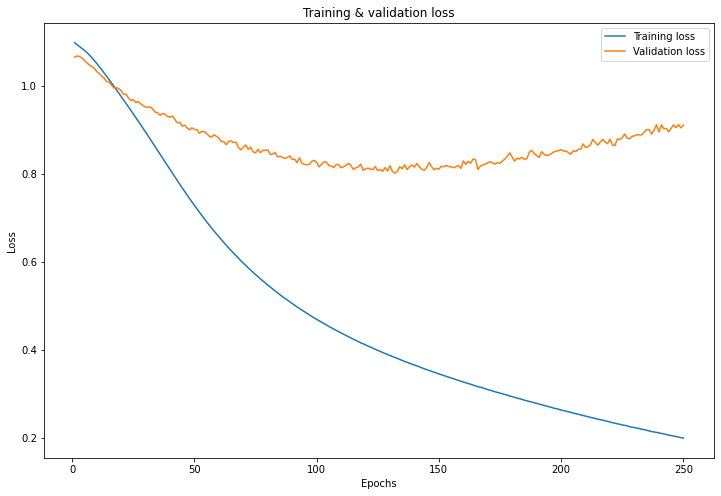

In [16]:
# Loss vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12,8))
loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']
epochs = range(1, len(loss_values)+1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')
ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

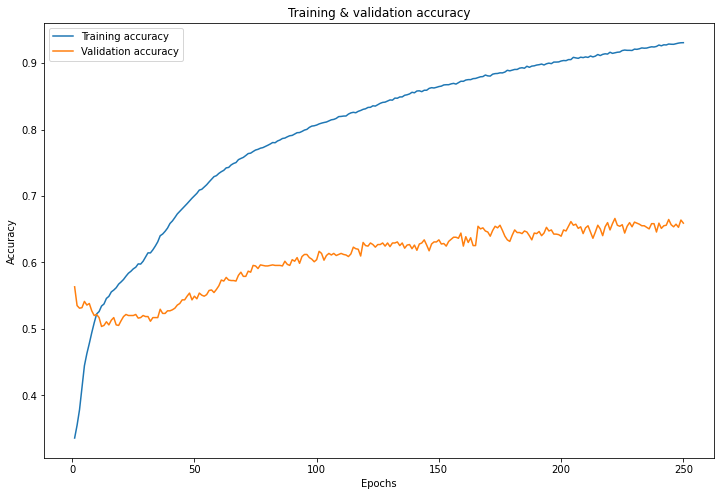

In [17]:
# Accuracy vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12,8))
acc_values = baseline_model_val_dict['accuracy']
val_acc_values = baseline_model_val_dict['val_accuracy']
ax.plot(epochs, acc_values, label='Training accuracy')
ax.plot(epochs, val_acc_values, label='Validation accuracy')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

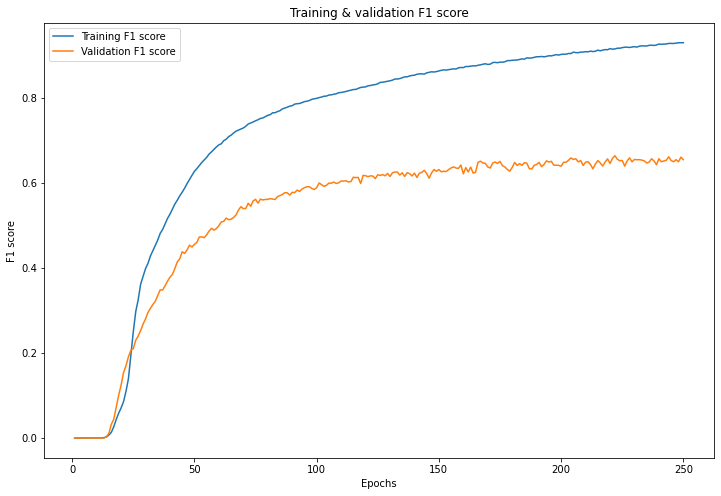

In [18]:
# F1 score vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12,8))
f1_values = baseline_model_val_dict['get_f1']
val_f1_values = baseline_model_val_dict['val_get_f1']
ax.plot(epochs, f1_values, label='Training F1 score')
ax.plot(epochs, val_f1_values, label='Validation F1 score')
ax.set_title('Training & validation F1 score')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 score')
ax.legend();

According to the plots, there is an interesting pattern: although the training accuracy and f1 score keep increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy, f1 score and loss don't necessarily do the same. After a certain point, validation accuracy keeps swinging, which means that the model is probably overfitting the training data when training for many epochs past a cetrain dropoff point.

Overfitting neural networks is something that should be avoided at all costs. However, it's not possible to know in advance how many epochs you need to train the model on, and running the model multiple times with varying number of epochs maybe helpfu, but it is a time-consuming process. An early stopping point when training the model was specified to tackle the problem.

### Model with Early Stopping
The model had the same architecture as above. A list `'early_stopping'` was defined. It monitored `'val_loss'` and continued training for 10 epochs before stopping. The best model while monitoring `'val_loss'` was saved.

In [19]:
# Build a baseline neural network model
random.seed(123)
model_stopping = models.Sequential()
model_stopping.add(layers.Dense(50, activation='relu', input_shape=(3000,)))
model_stopping.add(layers.Dense(25, activation='relu'))
model_stopping.add(layers.Dense(3, activation='softmax'))

model_stopping.compile(optimizer='SGD',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', get_f1])

In [20]:
# Import necessary libraries
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                  ModelCheckpoint(filepath='Images/best_model.h5',
                                  monitor='val_loss',
                                  save_best_only=True)]

In [21]:
# Train the model
model_stopping_val = model_stopping.fit(X_train_resampled,
                                        y_train_resampled,
                                        epochs=250,
                                        callbacks=early_stopping,
                                        batch_size=256,
                                        validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250
 6/37 [===>..........................] - ETA: 0s - loss: 1.0973 - accuracy: 0.3132 - get_f1: 0.0000e+00

2023-06-11 05:53:21.228954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 17ms/step - loss: 1.0963 - accuracy: 0.3235 - get_f1: 0.0000e+00 - val_loss: 1.0711 - val_accuracy: 0.5522 - val_get_f1: 0.0000e+00
Epoch 2/250
 1/37 [..............................] - ETA: 0s - loss: 1.0908 - accuracy: 0.3555 - get_f1: 0.0000e+00

2023-06-11 05:53:21.807820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 11ms/step - loss: 1.0932 - accuracy: 0.3471 - get_f1: 0.0000e+00 - val_loss: 1.0745 - val_accuracy: 0.5208 - val_get_f1: 0.0000e+00
Epoch 3/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0904 - accuracy: 0.3701 - get_f1: 0.0000e+00 - val_loss: 1.0749 - val_accuracy: 0.4933 - val_get_f1: 0.0000e+00
Epoch 4/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0874 - accuracy: 0.4003 - get_f1: 0.0000e+00 - val_loss: 1.0731 - val_accuracy: 0.4855 - val_get_f1: 0.0000e+00
Epoch 5/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0839 - accuracy: 0.4224 - get_f1: 0.0000e+00 - val_loss: 1.0698 - val_accuracy: 0.4925 - val_get_f1: 0.0000e+00
Epoch 6/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0800 - accuracy: 0.4391 - get_f1: 0.0000e+00 - val_loss: 1.0646 - val_accuracy: 0.5012 - val_get_f1: 0.0000e+00
Epoch 7/250
37/37 [==============================] - 0s 12ms/step - loss

Epoch 47/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7839 - accuracy: 0.6750 - get_f1: 0.5390 - val_loss: 0.9198 - val_accuracy: 0.5232 - val_get_f1: 0.3869
Epoch 48/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7758 - accuracy: 0.6793 - get_f1: 0.5489 - val_loss: 0.9182 - val_accuracy: 0.5240 - val_get_f1: 0.3910
Epoch 49/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7678 - accuracy: 0.6824 - get_f1: 0.5574 - val_loss: 0.9110 - val_accuracy: 0.5263 - val_get_f1: 0.3999
Epoch 50/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7598 - accuracy: 0.6871 - get_f1: 0.5672 - val_loss: 0.9115 - val_accuracy: 0.5247 - val_get_f1: 0.4078
Epoch 51/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7520 - accuracy: 0.6914 - get_f1: 0.5749 - val_loss: 0.9129 - val_accuracy: 0.5224 - val_get_f1: 0.4101
Epoch 52/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7443 - accuracy: 0

In [22]:
# Load the best (saved) model
from keras.models import load_model
saved_model = load_model('Images/best_model.h5', custom_objects={"get_f1": get_f1})

In [23]:
results_train = saved_model.evaluate(X_train_resampled, y_train_resampled)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3} \nTraining F1 Score: {results_train[2]:.3}')
print('-------')
results_test = saved_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3} \nTest F1 Score: {results_test[2]:.3}')

 12/294 [>.............................] - ETA: 2s - loss: 0.5852 - accuracy: 0.7240 - get_f1: 0.7129

2023-06-11 05:56:04.512455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 2s 8ms/step - loss: 0.4208 - accuracy: 0.8237 - get_f1: 0.8192
Training Loss: 0.421 
Training Accuracy: 0.824 
Training F1 Score: 0.819
-------
13/86 [===>..........................] - ETA: 0s - loss: 0.8433 - accuracy: 0.5889 - get_f1: 0.5828

2023-06-11 05:56:07.018239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 1s 8ms/step - loss: 0.8114 - accuracy: 0.6265 - get_f1: 0.6124
Test Loss: 0.811 
Test Accuracy: 0.626 
Test F1 Score: 0.612


The model didn't train for all 250 epochs. The training time was reduced and only 133 epochs were trained on. However, the results didn't differ much from the baseline model. Regularization techniques were tried out to further improve the model performance.

### Model with L2 Regularization
The model architecture was the same, however, L2 regularization to both the hidden layers with 0.005 as the `lambda_coeff` was added. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform.

In [24]:
# Import necessary libraries
from keras import regularizers

random.seed(123)
L2_model = models.Sequential()

# Add the layers
L2_model.add(layers.Dense(50,
                          activation='relu', 
                          kernel_regularizer=regularizers.l2(0.005),
                          input_shape=(3000,)))
L2_model.add(layers.Dense(25,
                          kernel_regularizer=regularizers.l2(0.005),
                          activation='relu'))
L2_model.add(layers.Dense(3, activation='softmax'))

In [25]:
# Compile the model
L2_model.compile(optimizer='SGD',
                 loss='categorical_crossentropy',
                 metrics=['accuracy', get_f1])

In [26]:
# Train the model
L2_model_val = L2_model.fit(X_train_resampled,
                            y_train_resampled,
                            epochs=250,
                            batch_size=256,
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250
 1/37 [..............................] - ETA: 11s - loss: 1.7577 - accuracy: 0.3203 - get_f1: 0.0000e+00

2023-06-11 05:56:13.219708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 23ms/step - loss: 1.7510 - accuracy: 0.3259 - get_f1: 0.0000e+00 - val_loss: 1.7232 - val_accuracy: 0.5530 - val_get_f1: 0.0000e+00
Epoch 2/250
 1/37 [..............................] - ETA: 0s - loss: 1.7443 - accuracy: 0.3398 - get_f1: 0.0000e+00

2023-06-11 05:56:14.039395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 12ms/step - loss: 1.7432 - accuracy: 0.3456 - get_f1: 0.0000e+00 - val_loss: 1.7219 - val_accuracy: 0.5208 - val_get_f1: 0.0000e+00
Epoch 3/250
37/37 [==============================] - 0s 12ms/step - loss: 1.7357 - accuracy: 0.3746 - get_f1: 0.0000e+00 - val_loss: 1.7178 - val_accuracy: 0.4925 - val_get_f1: 0.0000e+00
Epoch 4/250
37/37 [==============================] - 0s 11ms/step - loss: 1.7280 - accuracy: 0.4065 - get_f1: 0.0000e+00 - val_loss: 1.7112 - val_accuracy: 0.4886 - val_get_f1: 0.0000e+00
Epoch 5/250
37/37 [==============================] - 0s 12ms/step - loss: 1.7200 - accuracy: 0.4205 - get_f1: 0.0000e+00 - val_loss: 1.7036 - val_accuracy: 0.4910 - val_get_f1: 0.0000e+00
Epoch 6/250
37/37 [==============================] - 0s 12ms/step - loss: 1.7117 - accuracy: 0.4383 - get_f1: 0.0000e+00 - val_loss: 1.6948 - val_accuracy: 0.4933 - val_get_f1: 0.0000e+00
Epoch 7/250
37/37 [==============================] - 0s 12ms/step - loss

Epoch 47/250
37/37 [==============================] - 0s 11ms/step - loss: 1.2995 - accuracy: 0.6625 - get_f1: 0.4987 - val_loss: 1.4093 - val_accuracy: 0.5208 - val_get_f1: 0.3689
Epoch 48/250
37/37 [==============================] - 0s 11ms/step - loss: 1.2897 - accuracy: 0.6643 - get_f1: 0.5074 - val_loss: 1.4104 - val_accuracy: 0.5145 - val_get_f1: 0.3658
Epoch 49/250
37/37 [==============================] - 0s 11ms/step - loss: 1.2799 - accuracy: 0.6693 - get_f1: 0.5156 - val_loss: 1.3984 - val_accuracy: 0.5232 - val_get_f1: 0.3800
Epoch 50/250
37/37 [==============================] - 0s 11ms/step - loss: 1.2704 - accuracy: 0.6723 - get_f1: 0.5229 - val_loss: 1.4026 - val_accuracy: 0.5200 - val_get_f1: 0.3720
Epoch 51/250
37/37 [==============================] - 0s 11ms/step - loss: 1.2609 - accuracy: 0.6769 - get_f1: 0.5308 - val_loss: 1.3894 - val_accuracy: 0.5208 - val_get_f1: 0.3902
Epoch 52/250
37/37 [==============================] - 0s 11ms/step - loss: 1.2514 - accuracy: 0

37/37 [==============================] - 0s 11ms/step - loss: 0.7762 - accuracy: 0.8187 - get_f1: 0.8091 - val_loss: 1.1380 - val_accuracy: 0.6088 - val_get_f1: 0.5953
Epoch 138/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7730 - accuracy: 0.8186 - get_f1: 0.8101 - val_loss: 1.1394 - val_accuracy: 0.6057 - val_get_f1: 0.5925
Epoch 139/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7698 - accuracy: 0.8196 - get_f1: 0.8114 - val_loss: 1.1294 - val_accuracy: 0.6159 - val_get_f1: 0.6006
Epoch 140/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7666 - accuracy: 0.8210 - get_f1: 0.8130 - val_loss: 1.1334 - val_accuracy: 0.6088 - val_get_f1: 0.5958
Epoch 141/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7638 - accuracy: 0.8219 - get_f1: 0.8119 - val_loss: 1.1242 - val_accuracy: 0.6167 - val_get_f1: 0.6031
Epoch 142/250
37/37 [==============================] - 0s 11ms/step - loss: 0.7604 - accuracy: 0.8222 - 

37/37 [==============================] - 0s 11ms/step - loss: 0.5674 - accuracy: 0.8844 - get_f1: 0.8806 - val_loss: 1.0336 - val_accuracy: 0.6300 - val_get_f1: 0.6245
Epoch 228/250
37/37 [==============================] - 0s 11ms/step - loss: 0.5657 - accuracy: 0.8826 - get_f1: 0.8790 - val_loss: 1.0271 - val_accuracy: 0.6465 - val_get_f1: 0.6422
Epoch 229/250
37/37 [==============================] - 0s 11ms/step - loss: 0.5643 - accuracy: 0.8830 - get_f1: 0.8798 - val_loss: 1.0412 - val_accuracy: 0.6245 - val_get_f1: 0.6201
Epoch 230/250
37/37 [==============================] - 0s 11ms/step - loss: 0.5627 - accuracy: 0.8848 - get_f1: 0.8816 - val_loss: 1.0350 - val_accuracy: 0.6284 - val_get_f1: 0.6204
Epoch 231/250
37/37 [==============================] - 0s 11ms/step - loss: 0.5610 - accuracy: 0.8836 - get_f1: 0.8801 - val_loss: 1.0245 - val_accuracy: 0.6402 - val_get_f1: 0.6328
Epoch 232/250
37/37 [==============================] - 0s 11ms/step - loss: 0.5595 - accuracy: 0.8857 - 

In [27]:
results_train = L2_model.evaluate(X_train_resampled, y_train_resampled)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3} \nTraining F1 Score: {results_train[2]:.3}')
print('-------')
results_test = L2_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3} \nTest F1 Score: {results_test[2]:.3}')

  5/294 [..............................] - ETA: 3s - loss: 0.6653 - accuracy: 0.8250 - get_f1: 0.8211 

2023-06-11 05:58:09.464839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 0.5289 - accuracy: 0.8955 - get_f1: 0.8923
Training Loss: 0.529 
Training Accuracy: 0.895 
Training F1 Score: 0.892
-------
86/86 [==============================] - 1s 9ms/step - loss: 1.0308 - accuracy: 0.6551 - get_f1: 0.6391
Test Loss: 1.03 
Test Accuracy: 0.655 
Test F1 Score: 0.639


The accuracy and F1 scores for baseline and L2 models were compared.

In [28]:
# L2 model details
L2_model_dict = L2_model_val.history
L2_acc_values = L2_model_dict['accuracy']
L2_val_acc_values = L2_model_dict['val_accuracy']
L2_f1_values = L2_model_dict['get_f1']
L2_val_f1_values = L2_model_dict['val_get_f1']

# Baseline model details
baseline_model_acc = baseline_model_val_dict['accuracy']
baseline_model_val_acc = baseline_model_val_dict['val_accuracy']
baseline_model_f1 = baseline_model_val_dict['get_f1']
baseline_model_val_f1 = baseline_model_val_dict['val_get_f1']

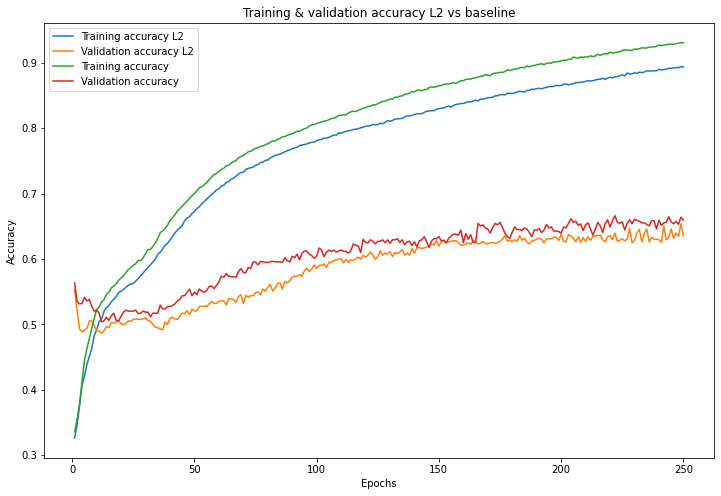

In [29]:
# Plot accuracy for both models
fig, ax = plt.subplots(figsize=(12,8))
epochs = range(1, len(acc_values)+1)
ax.plot(epochs, L2_acc_values, label='Training accuracy L2')
ax.plot(epochs, L2_val_acc_values, label='Validation accuracy L2')
ax.plot(epochs, baseline_model_acc, label='Training accuracy')
ax.plot(epochs, baseline_model_val_acc, label='Validation accuracy')
ax.set_title('Training & validation accuracy L2 vs baseline')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

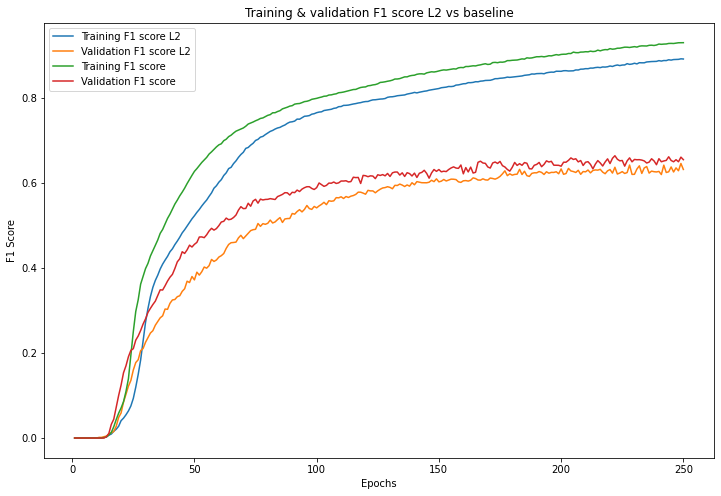

In [30]:
# Plot F1 score for both models
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epochs, L2_f1_values, label='Training F1 score L2')
ax.plot(epochs, L2_val_f1_values, label='Validation F1 score L2')
ax.plot(epochs, baseline_model_f1, label='Training F1 score')
ax.plot(epochs, baseline_model_val_f1, label='Validation F1 score')
ax.set_title('Training & validation F1 score L2 vs baseline')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 Score')
ax.legend();

The results of L2 regularization were quite disappointing: they were not getting any better. L1 regularization was tried out if it could bring any improvement.

### Model with L1 Regularization
The architecture of the model remained the same. L1 regularization to both the hidden layers with 0.005 as the `lambda_coeff` was added.

In [31]:
random.seed(123)
L1_model = models.Sequential()

# Add the layers
L1_model.add(layers.Dense(50,
                          activation='relu', 
                          kernel_regularizer=regularizers.l1(0.005),
                          input_shape=(3000,)))
L1_model.add(layers.Dense(25,
                          kernel_regularizer=regularizers.l1(0.005),
                          activation='relu'))
L1_model.add(layers.Dense(3, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='SGD',
                 loss='categorical_crossentropy',
                 metrics=['accuracy', get_f1])

# Train the model
L1_model_val = L1_model.fit(X_train_resampled,
                            y_train_resampled,
                            epochs=250,
                            batch_size=256,
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250
 1/37 [..............................] - ETA: 10s - loss: 18.5878 - accuracy: 0.2969 - get_f1: 0.0000e+00

2023-06-11 05:58:36.286916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 20ms/step - loss: 17.9176 - accuracy: 0.3252 - get_f1: 0.0000e+00 - val_loss: 17.1901 - val_accuracy: 0.5499 - val_get_f1: 0.0000e+00
Epoch 2/250
 1/37 [..............................] - ETA: 0s - loss: 17.2104 - accuracy: 0.3555 - get_f1: 0.0000e+00

2023-06-11 05:58:36.985737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 12ms/step - loss: 16.5738 - accuracy: 0.3480 - get_f1: 0.0000e+00 - val_loss: 15.8841 - val_accuracy: 0.5200 - val_get_f1: 0.0000e+00
Epoch 3/250
37/37 [==============================] - 0s 12ms/step - loss: 15.2886 - accuracy: 0.3790 - get_f1: 0.0000e+00 - val_loss: 14.6329 - val_accuracy: 0.4925 - val_get_f1: 0.0000e+00
Epoch 4/250
37/37 [==============================] - 0s 12ms/step - loss: 14.0614 - accuracy: 0.4116 - get_f1: 0.0000e+00 - val_loss: 13.4375 - val_accuracy: 0.4815 - val_get_f1: 0.0000e+00
Epoch 5/250
37/37 [==============================] - 0s 12ms/step - loss: 12.8920 - accuracy: 0.4356 - get_f1: 0.0000e+00 - val_loss: 12.2993 - val_accuracy: 0.4705 - val_get_f1: 0.0000e+00
Epoch 6/250
37/37 [==============================] - 0s 12ms/step - loss: 11.7809 - accuracy: 0.4486 - get_f1: 0.0000e+00 - val_loss: 11.2180 - val_accuracy: 0.4831 - val_get_f1: 0.0000e+00
Epoch 7/250
37/37 [==============================] - 0s 12ms/s

Epoch 46/250
37/37 [==============================] - 0s 11ms/step - loss: 1.5252 - accuracy: 0.4860 - get_f1: 0.0318 - val_loss: 1.5304 - val_accuracy: 0.4485 - val_get_f1: 0.0485
Epoch 47/250
37/37 [==============================] - 0s 11ms/step - loss: 1.5168 - accuracy: 0.4870 - get_f1: 0.0335 - val_loss: 1.5185 - val_accuracy: 0.4564 - val_get_f1: 0.0514
Epoch 48/250
37/37 [==============================] - 0s 12ms/step - loss: 1.5085 - accuracy: 0.4882 - get_f1: 0.0345 - val_loss: 1.5166 - val_accuracy: 0.4493 - val_get_f1: 0.0529
Epoch 49/250
37/37 [==============================] - 0s 12ms/step - loss: 1.5001 - accuracy: 0.4875 - get_f1: 0.0367 - val_loss: 1.5082 - val_accuracy: 0.4509 - val_get_f1: 0.0544
Epoch 50/250
37/37 [==============================] - 0s 12ms/step - loss: 1.4918 - accuracy: 0.4884 - get_f1: 0.0383 - val_loss: 1.4971 - val_accuracy: 0.4533 - val_get_f1: 0.0630
Epoch 51/250
37/37 [==============================] - 0s 11ms/step - loss: 1.4836 - accuracy: 0

37/37 [==============================] - 0s 11ms/step - loss: 1.0252 - accuracy: 0.5707 - get_f1: 0.4212 - val_loss: 1.1121 - val_accuracy: 0.4925 - val_get_f1: 0.2991
Epoch 137/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0225 - accuracy: 0.5713 - get_f1: 0.4238 - val_loss: 1.1135 - val_accuracy: 0.4925 - val_get_f1: 0.2981
Epoch 138/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0196 - accuracy: 0.5732 - get_f1: 0.4252 - val_loss: 1.1159 - val_accuracy: 0.4870 - val_get_f1: 0.2971
Epoch 139/250
37/37 [==============================] - 0s 12ms/step - loss: 1.0172 - accuracy: 0.5727 - get_f1: 0.4267 - val_loss: 1.1076 - val_accuracy: 0.4902 - val_get_f1: 0.3047
Epoch 140/250
37/37 [==============================] - 0s 11ms/step - loss: 1.0146 - accuracy: 0.5753 - get_f1: 0.4287 - val_loss: 1.1096 - val_accuracy: 0.4918 - val_get_f1: 0.3043
Epoch 141/250
37/37 [==============================] - 0s 12ms/step - loss: 1.0121 - accuracy: 0.5765 - 

37/37 [==============================] - 0s 11ms/step - loss: 0.8794 - accuracy: 0.6548 - get_f1: 0.5435 - val_loss: 1.1066 - val_accuracy: 0.5067 - val_get_f1: 0.3729
Epoch 227/250
37/37 [==============================] - 0s 11ms/step - loss: 0.8787 - accuracy: 0.6558 - get_f1: 0.5439 - val_loss: 1.0850 - val_accuracy: 0.5302 - val_get_f1: 0.4002
Epoch 228/250
37/37 [==============================] - 0s 12ms/step - loss: 0.8780 - accuracy: 0.6570 - get_f1: 0.5409 - val_loss: 1.1001 - val_accuracy: 0.5161 - val_get_f1: 0.3780
Epoch 229/250
37/37 [==============================] - 0s 12ms/step - loss: 0.8765 - accuracy: 0.6592 - get_f1: 0.5439 - val_loss: 1.1056 - val_accuracy: 0.5106 - val_get_f1: 0.3724
Epoch 230/250
37/37 [==============================] - 0s 12ms/step - loss: 0.8756 - accuracy: 0.6579 - get_f1: 0.5416 - val_loss: 1.1082 - val_accuracy: 0.5122 - val_get_f1: 0.3714
Epoch 231/250
37/37 [==============================] - 0s 12ms/step - loss: 0.8748 - accuracy: 0.6579 - 

In [32]:
results_train = L1_model.evaluate(X_train_resampled, y_train_resampled)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3} \nTraining F1 Score: {results_train[2]:.3}')
print('-------')
results_test = L1_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3} \nTest F1 Score: {results_test[2]:.3}')

  5/294 [..............................] - ETA: 4s - loss: 0.9855 - accuracy: 0.5562 - get_f1: 0.4592 

2023-06-11 06:00:36.550901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 0.8596 - accuracy: 0.6610 - get_f1: 0.5212
Training Loss: 0.86 
Training Accuracy: 0.661 
Training F1 Score: 0.521
-------
86/86 [==============================] - 1s 10ms/step - loss: 1.0687 - accuracy: 0.5334 - get_f1: 0.4060
Test Loss: 1.07 
Test Accuracy: 0.533 
Test F1 Score: 0.406


The results of the F1 score and accuracy became even worse. The training and validation accuracy and F1 scores for the L1 model were plotted.

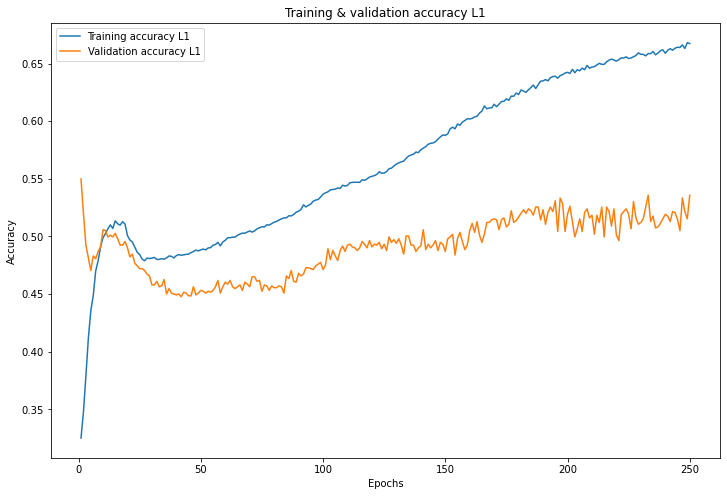

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
L1_model_dict = L1_model_val.history
acc_values = L1_model_dict['accuracy']
val_acc_values = L1_model_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)
ax.plot(epochs, acc_values, label='Training accuracy L1')
ax.plot(epochs, val_acc_values, label='Validation accuracy L1')
ax.set_title('Training & validation accuracy L1')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

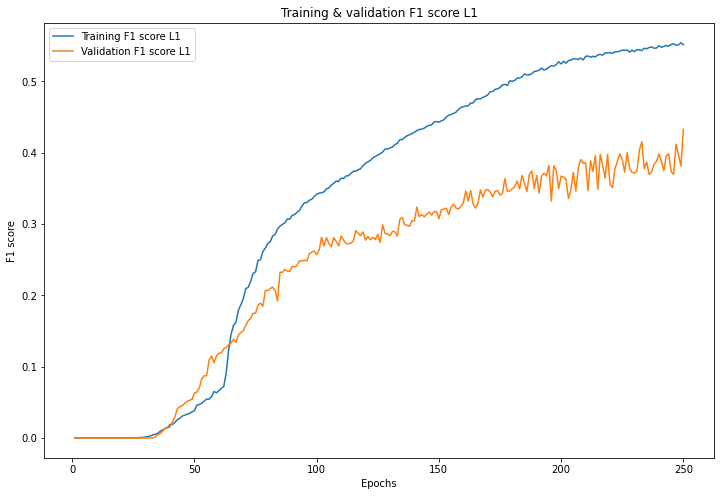

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

f1_values = L1_model_dict['get_f1']
val_f1_values = L1_model_dict['val_get_f1']

ax.plot(epochs, f1_values, label='Training F1 score L1')
ax.plot(epochs, val_f1_values, label='Validation F1 score L1')
ax.set_title('Training & validation F1 score L1')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 score')
ax.legend();

Although the training and validation accuracy and F1 scores didn't diverge as much as before, the results were very disapponting. Dropout regularization was experimented with to see if it could offer any advantages.

### Model with Dropout Regularization
Dropout was applied to layers. This involved setting a certain proportion of units in each layer to zero.
* A dropout rate of 30% was applied to the input layer
* A first hidden layer with 50 units and `'relu'` activation was added
* A dropout rate of 30% was applied to the first hidden layer
* A second hidden layer with 25 units and `'relu'` activation was added
* A dropout rate of 30% was applied to the second hidden layer

In [35]:
random.seed(123)
dropout_model = models.Sequential()

# Add the layers
dropout_model.add(layers.Dropout(0.3, input_shape=(3000,)))
dropout_model.add(layers.Dense(50, activation='relu'))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(25, activation='relu'))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(3, activation='softmax'))

# Compile the model
dropout_model.compile(optimizer='SGD',
                      loss='categorical_crossentropy',
                      metrics=['accuracy', get_f1])

# Train the model
dropout_model_val = dropout_model.fit(X_train_resampled,
                                      y_train_resampled,
                                      epochs=250,
                                      batch_size=256,
                                      validation_data=(X_val_tokens, y_val_lb))

Epoch 1/250


2023-06-11 06:00:54.457425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 24ms/step - loss: 1.0984 - accuracy: 0.3262 - get_f1: 4.1984e-04 - val_loss: 1.0762 - val_accuracy: 0.5365 - val_get_f1: 0.0000e+00
Epoch 2/250


2023-06-11 06:00:55.333547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 14ms/step - loss: 1.0947 - accuracy: 0.3391 - get_f1: 3.1427e-04 - val_loss: 1.0831 - val_accuracy: 0.4635 - val_get_f1: 0.0000e+00
Epoch 3/250
37/37 [==============================] - 0s 14ms/step - loss: 1.0913 - accuracy: 0.3583 - get_f1: 0.0000e+00 - val_loss: 1.0863 - val_accuracy: 0.4242 - val_get_f1: 0.0000e+00
Epoch 4/250
37/37 [==============================] - 0s 14ms/step - loss: 1.0904 - accuracy: 0.3701 - get_f1: 0.0000e+00 - val_loss: 1.0891 - val_accuracy: 0.3912 - val_get_f1: 0.0000e+00
Epoch 5/250
37/37 [==============================] - 0s 13ms/step - loss: 1.0873 - accuracy: 0.3838 - get_f1: 0.0000e+00 - val_loss: 1.0888 - val_accuracy: 0.3896 - val_get_f1: 0.0000e+00
Epoch 6/250
37/37 [==============================] - 0s 13ms/step - loss: 1.0845 - accuracy: 0.3934 - get_f1: 6.3098e-04 - val_loss: 1.0875 - val_accuracy: 0.3904 - val_get_f1: 0.0000e+00
Epoch 7/250
37/37 [==============================] - 0s 13ms/step - loss

Epoch 47/250
37/37 [==============================] - 0s 13ms/step - loss: 0.9253 - accuracy: 0.5520 - get_f1: 0.3706 - val_loss: 0.9700 - val_accuracy: 0.5027 - val_get_f1: 0.2203
Epoch 48/250
37/37 [==============================] - 0s 13ms/step - loss: 0.9245 - accuracy: 0.5566 - get_f1: 0.3733 - val_loss: 0.9694 - val_accuracy: 0.5043 - val_get_f1: 0.2227
Epoch 49/250
37/37 [==============================] - 0s 13ms/step - loss: 0.9190 - accuracy: 0.5584 - get_f1: 0.3808 - val_loss: 0.9712 - val_accuracy: 0.4965 - val_get_f1: 0.2135
Epoch 50/250
37/37 [==============================] - 0s 13ms/step - loss: 0.9121 - accuracy: 0.5698 - get_f1: 0.3902 - val_loss: 0.9626 - val_accuracy: 0.5020 - val_get_f1: 0.2352
Epoch 51/250
37/37 [==============================] - 0s 13ms/step - loss: 0.9090 - accuracy: 0.5671 - get_f1: 0.3969 - val_loss: 0.9712 - val_accuracy: 0.4949 - val_get_f1: 0.2302
Epoch 52/250
37/37 [==============================] - 0s 13ms/step - loss: 0.9021 - accuracy: 0

37/37 [==============================] - 0s 13ms/step - loss: 0.6369 - accuracy: 0.7098 - get_f1: 0.6874 - val_loss: 0.8405 - val_accuracy: 0.5813 - val_get_f1: 0.5372
Epoch 138/250
37/37 [==============================] - 0s 13ms/step - loss: 0.6312 - accuracy: 0.7189 - get_f1: 0.6939 - val_loss: 0.8357 - val_accuracy: 0.5821 - val_get_f1: 0.5459
Epoch 139/250
37/37 [==============================] - 0s 13ms/step - loss: 0.6356 - accuracy: 0.7139 - get_f1: 0.6870 - val_loss: 0.8402 - val_accuracy: 0.5837 - val_get_f1: 0.5411
Epoch 140/250
37/37 [==============================] - 0s 13ms/step - loss: 0.6349 - accuracy: 0.7106 - get_f1: 0.6829 - val_loss: 0.8359 - val_accuracy: 0.5797 - val_get_f1: 0.5447
Epoch 141/250
37/37 [==============================] - 0s 13ms/step - loss: 0.6267 - accuracy: 0.7114 - get_f1: 0.6902 - val_loss: 0.8383 - val_accuracy: 0.5813 - val_get_f1: 0.5418
Epoch 142/250
37/37 [==============================] - 0s 13ms/step - loss: 0.6285 - accuracy: 0.7147 - 

37/37 [==============================] - 0s 13ms/step - loss: 0.5158 - accuracy: 0.7685 - get_f1: 0.7586 - val_loss: 0.8033 - val_accuracy: 0.6300 - val_get_f1: 0.6121
Epoch 228/250
37/37 [==============================] - 0s 13ms/step - loss: 0.5122 - accuracy: 0.7738 - get_f1: 0.7651 - val_loss: 0.8146 - val_accuracy: 0.6151 - val_get_f1: 0.5979
Epoch 229/250
37/37 [==============================] - 0s 13ms/step - loss: 0.5107 - accuracy: 0.7776 - get_f1: 0.7661 - val_loss: 0.8067 - val_accuracy: 0.6253 - val_get_f1: 0.6070
Epoch 230/250
37/37 [==============================] - 0s 13ms/step - loss: 0.5071 - accuracy: 0.7793 - get_f1: 0.7671 - val_loss: 0.8114 - val_accuracy: 0.6300 - val_get_f1: 0.6033
Epoch 231/250
37/37 [==============================] - 0s 13ms/step - loss: 0.5084 - accuracy: 0.7776 - get_f1: 0.7684 - val_loss: 0.8023 - val_accuracy: 0.6284 - val_get_f1: 0.6110
Epoch 232/250
37/37 [==============================] - 0s 13ms/step - loss: 0.5100 - accuracy: 0.7740 - 

In [36]:
results_train = dropout_model.evaluate(X_train_resampled, y_train_resampled)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3} \nTraining F1 Score: {results_train[2]:.3}')
print('-------')
results_test = dropout_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3} \nTest F1 Score: {results_test[2]:.3}')

  4/294 [..............................] - ETA: 4s - loss: 0.5436 - accuracy: 0.7656 - get_f1: 0.7406 

2023-06-11 06:03:21.594669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 3s 9ms/step - loss: 0.3756 - accuracy: 0.8618 - get_f1: 0.8556
Training Loss: 0.376 
Training Accuracy: 0.862 
Training F1 Score: 0.856
-------
86/86 [==============================] - 1s 10ms/step - loss: 0.8049 - accuracy: 0.6136 - get_f1: 0.5949
Test Loss: 0.805 
Test Accuracy: 0.614 
Test F1 Score: 0.595


The results didn't get better and were quite disapponting.

Among the various neural network models built for the task at hand, the Baseline model demonstrated the best performance, boasting the F1 score of 65% and an accuracy of 65%. This model, with its minimal complexity and straightforward architecture, emerged as the frontrunner among its counterparts.
***

### Model Evaluation
Based on the F1 scores of the built neural network models, the Baseline Neural Network showed the best results. While the F1 score of 65% is not considered a perfect result, it undoubtedly standed out when compared to the outcomes achieved by the regular machine learning algorithms. The 65% F1 score represented a significant improvement over the Logistic Regression model with the F1 score of 57%, indicating substantial progress in the task at hand.

The leap from the Logistic Regression to a 65% F1 score signified a substantial advancement in the model's balanced ability to both capture Tweets (recall) and be accurate with those Tweets (precision), while correctly identifing a Tweet about 65% of the time.

In conclusion, while the F1 score of 65% may fall short of perfection, it stands out as a remarkable achievement when compared to the results obtained from traditional machine learning algorithms. This significant improvement signifies the model's ability to overcome previous limitations and highlights the promising prospects for future advancements in the field.
***

### Conclusions
In conclusion, the Baseline Neural Network model emerged as the top-performing model, demonstrating superior results compared to other algorithms. However, it is important to note that even though it showcased a better F1 score, it was not perfect. One possible reason for the model's imperfection could be the limited size of the dataset.

Neural networks, with their ability to learn complex patterns and relationships, often require large amounts of data to generalize effectively. With a small dataset, the neural network may not have had enough diverse examples to fully capture the underlying patterns and variations present in the target problem.

Despite this limitation, the neural network's ability to outperform other algorithms highlights its potential and robustness. Its superior performance suggests that with a larger and more diverse dataset, the model could potentially achieve even better results.

It is worth emphasizing the importance of data in training accurate and reliable machine learning models. While the neural network showed the best F1 score among the models built, it is crucial to consider the quality and quantity of data available. Collecting and curating a larger dataset could potentially enhance the model's performance and address its imperfections.

Overall, while the Baseline Neural Network model demonstrated the best F1 score, the presence of imperfection suggests that further research and development are necessary to overcome limitations associated with dataset size. More data should be collected for achieving higher levels of F1 score and accuracy.
***